In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import gradio as gr
import shap

In [71]:
df = pd.read_csv("Sleep_health_and_lifestyle_dataset.csv")

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   Blood Pressure           374 non-null    object 
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           155 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 38.1+ KB


In [73]:
df.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [74]:
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
df['gender'] = df['gender'].str.lower()
df['occupation'] = df['occupation'].str.lower()
df['bmi_category'] = df['bmi_category'].str.lower()

In [75]:
label_cols = ['gender', 'occupation', 'bmi_category']
le_dict = {}
for col in label_cols:
    le = LabelEncoder()
    df[col + '_encoded'] = le.fit_transform(df[col])
    le_dict[col] = le

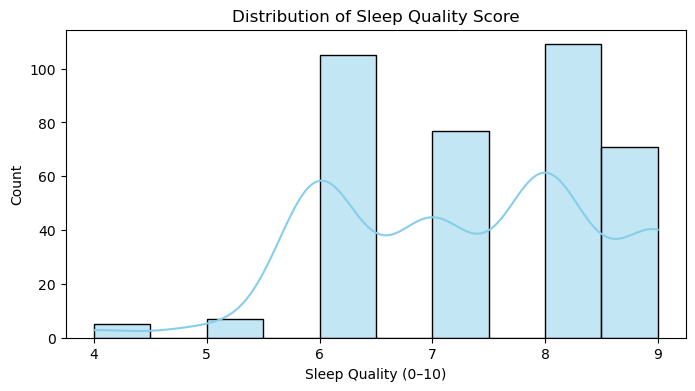

In [76]:
plt.figure(figsize=(8, 4))
sns.histplot(df['quality_of_sleep'], kde=True, bins=10, color='skyblue')
plt.title("Distribution of Sleep Quality Score")
plt.xlabel("Sleep Quality (0–10)")
plt.ylabel("Count")
plt.show()

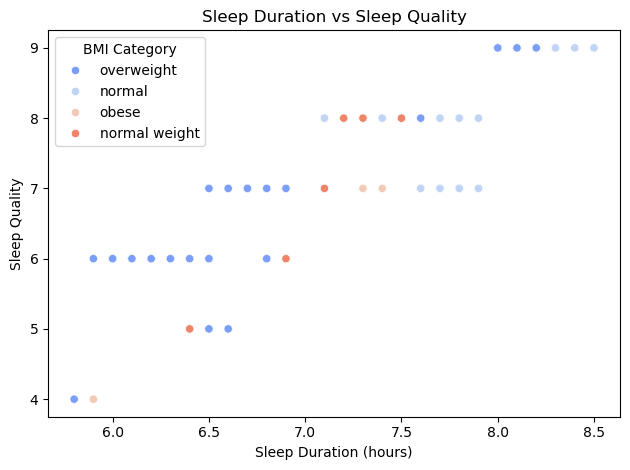

In [77]:
sns.scatterplot(x='sleep_duration', y='quality_of_sleep', data=df, hue='bmi_category', palette='coolwarm')
plt.title("Sleep Duration vs Sleep Quality")
plt.xlabel("Sleep Duration (hours)")
plt.ylabel("Sleep Quality")
plt.legend(title='BMI Category')
plt.tight_layout()
plt.show()

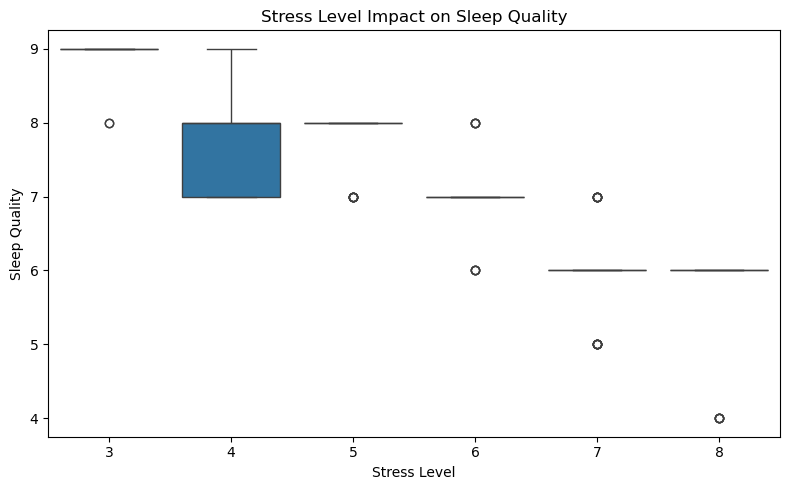

In [78]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='stress_level', y='quality_of_sleep', data=df)
plt.title("Stress Level Impact on Sleep Quality")
plt.xlabel("Stress Level")
plt.ylabel("Sleep Quality")
plt.tight_layout()
plt.show()

In [79]:
features = [
    'age', 'physical_activity_level', 'stress_level',
    'gender_encoded', 'occupation_encoded', 'bmi_category_encoded',
    'sleep_duration', 'heart_rate'
]

target = 'quality_of_sleep'

X = df[features]
y = df[target]

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [81]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [82]:
tolerance = 0.5
accuracy = np.mean(np.abs(y_test - y_pred) <= tolerance)
print(f"Test RMSE: {rmse:.2f}")
print(f"Custom Accuracy (±{tolerance}): {accuracy * 100:.2f}%")

Test RMSE: 0.12
Custom Accuracy (±0.5): 98.67%


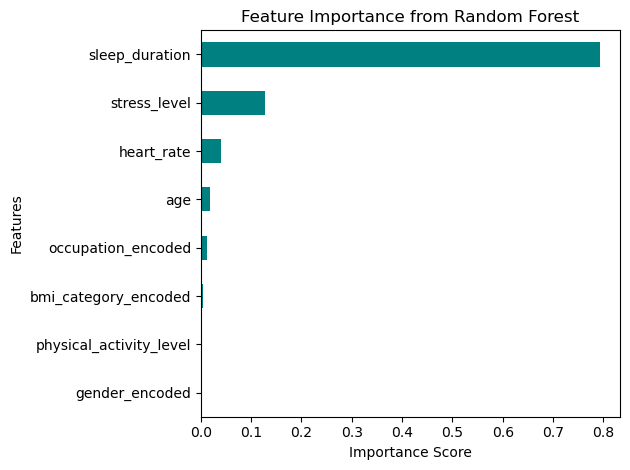

In [83]:
feat_imp = pd.Series(model.feature_importances_, index=features).sort_values()
feat_imp.plot(kind='barh', color='teal')
plt.title("Feature Importance from Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

In [84]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

In [85]:
def recommend_sleep(age, gender, occupation, sleep_duration, physical_activity, stress_level, bmi_category, heart_rate):
    gender_enc = le_dict['gender'].transform([gender.lower()])[0]
    occupation_enc = le_dict['occupation'].transform([occupation.lower()])[0]
    bmi_enc = le_dict['bmi_category'].transform([bmi_category.lower()])[0]

    input_df = pd.DataFrame([[
        age, physical_activity, stress_level,
        gender_enc, occupation_enc, bmi_enc, sleep_duration, heart_rate
    ]], columns=features)

    predicted_quality = model.predict(input_df)[0]
    shap_val = explainer.shap_values(input_df)[0]

    recs = []
    target_sleep = 7.5

    if sleep_duration < target_sleep:
        recs.append(f"Increase sleep duration to at least {target_sleep} hours.")

    if stress_level > 6:
        recs.append("Try stress reduction techniques: meditation, breathing, less caffeine.")

    if physical_activity < 60:
        recs.append("Aim for at least 60 minutes of physical activity daily.")

    if bmi_enc != le_dict['bmi_category'].transform(['normal'])[0]:
        recs.append("Work towards maintaining a normal BMI for better sleep quality.")

    if heart_rate > 80:  # tweak threshold as needed
        recs.append("Your resting heart rate is elevated—try light cardio, hydration, and stress relief.")

    recs.append(f"\npredicted Sleep Quality Score: {predicted_quality:.2f} / 10")

    feature_impact = sorted(zip(features, shap_val), key=lambda x: abs(x[1]), reverse=True)[:3]
    recs.append("\nTop Influencing Factors:")
    for feat, val in feature_impact:
        sign = "↑" if val > 0 else "↓"
        recs.append(f" - {feat}: {sign} ({val:.3f})")

    return "\n".join(recs)


In [86]:
def gradio_interface(age, gender, occupation, sleep_duration, physical_activity, stress_level, bmi_category, heart_rate):
    return recommend_sleep(age, gender, occupation, sleep_duration, physical_activity, stress_level, bmi_category, heart_rate)


gender_list = list(le_dict['gender'].classes_)
occupation_list = list(le_dict['occupation'].classes_)
bmi_list = list(le_dict['bmi_category'].classes_)

iface = gr.Interface(
    fn=gradio_interface,
    inputs=[
        gr.Number(label="Age", value=30, precision=0),
        gr.Dropdown(gender_list, label="Gender"),
        gr.Dropdown(occupation_list, label="Occupation"),
        gr.Number(label="Sleep Duration (hours)", value=6.5, precision=1),
        gr.Number(label="Physical Activity Level (minutes/day)", value=30, precision=0),
        gr.Slider(0, 10, value=5, step=1, label="Stress Level"),
        gr.Dropdown(bmi_list, label="BMI Category"),
        gr.Number(label="Resting Heart Rate (bpm)", value=72, precision=0)
    ],
    outputs="text",
    title="AI Sleep Coach",
    description="Get a personalized sleep quality prediction with actionable advice based on your lifestyle!"
)

iface.launch(share=True)


* Running on local URL:  http://127.0.0.1:7877


python(76073) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


* Running on public URL: https://2f1ce80161bf4950d8.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
